In [16]:
import numpy as np
import cv2

import time
from IPython.display import clear_output

import matplotlib.pyplot as plt
import os

In [2]:
data_path = "/home/ari/sim/data/tub_1_19-12-03/"

In [3]:
files = os.listdir("/home/ari/sim/data/tub_1_19-12-03/")
records = sorted(list(filter(lambda x: "record" in x, files)))
numbers = max(list(map(lambda x: int(x.split("_")[1].split(".")[0]), records)))

In [4]:
files[0]

'1269_cam-image_array_.jpg'

In [20]:
img = cv2.imread(data_path + str(1) + "_cam-image_array_.jpg", )

In [42]:
fast = cv2.FastFeatureDetector_create()

img = cv2.imread(data_path + str(1) + "_cam-image_array_.jpg", 0)
# find and draw the keypoints
kp = fast.detect(img)
img2 = cv2.drawKeypoints(img, kp, 0, color=(255,0,0))

cv2.imwrite('fast_true.png',img2)

# Disable nonmaxSuppression
fast.setNonmaxSuppression(True)
kp = fast.detect(img,None)

img3 = cv2.drawKeypoints(img, kp, 0, color=(255,0,0))

cv2.imwrite('fast_false.png',img3)

True

In [61]:
p1 = data_path + str(250) + "_cam-image_array_.jpg"
p2 = data_path + str(252) + "_cam-image_array_.jpg"


img1 = cv2.imread(p1,0)          # queryImage
img2 = cv2.imread(p2,0)          # trainImage

# Initiate SIFT detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

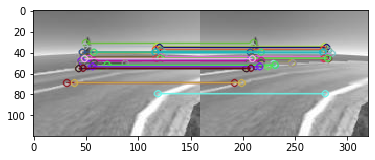

(<matplotlib.image.AxesImage at 0x7f132ec46c90>, None)

In [63]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:100], 0, flags=2)

plt.imshow(img3),plt.show()

In [93]:
points1 = cv2.KeyPoint_convert(kp1)
points2 = cv2.KeyPoint_convert(kp2)

E, _ = cv2.findEssentialMat(points1, points2)

In [94]:
r, t, _, _ = cv2.recoverPose(E, points1, points2)

In [95]:
r

0

array([[ 1.00000000e+00, -5.55111512e-17,  1.66533454e-16],
       [-5.55111512e-17,  1.00000000e+00, -1.66533454e-16],
       [ 0.00000000e+00,  1.11022302e-16,  1.00000000e+00]])

In [104]:
import json
times = []
for i in range(numbers):
    p = data_path + "record_{}.json".format(i + 1)
    with open(p, "r") as f:
        data = json.loads(f.read())
        times.append(data["milliseconds"])

In [ ]:
for i in range(numbers - 1):
    p1 = data_path + str(i + 1) + "_cam-image_array_.jpg"
    p2 = data_path + str(i + 2) + "_cam-image_array_.jpg"
    t1 = times[i]
    
    img1 = cv2.imread(p1,0)          # queryImage
    img2 = cv2.imread(p2,0)          # trainImage

    # Initiate SIFT detector
    orb = cv2.ORB_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Draw first 10 matches.
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:100], 0, flags=2)

    points1 = cv2.KeyPoint_convert(kp1)
    points2 = cv2.KeyPoint_convert(kp2)

    E, _ = cv2.findEssentialMat(points1, points2)
    
    r, t, _, _ = cv2.recoverPose(E, points1, points2)

In [102]:
times

[40437,
 40486,
 40537,
 40587,
 40645,
 40689,
 40750,
 40798,
 40842,
 40895,
 40944,
 40994,
 41042,
 41094,
 41145,
 41196,
 41246,
 41297,
 41344,
 41395,
 41446,
 41498,
 41545,
 41600,
 41648,
 41699,
 41748,
 41799,
 41855,
 41906,
 41957,
 42003,
 42061,
 42110,
 42162,
 42210,
 42261,
 42312,
 42364,
 42411,
 42463,
 42513,
 42562,
 42612,
 42662,
 42714,
 42767,
 42819,
 42866,
 42916,
 42967,
 43021,
 43071,
 43119,
 43170,
 43218,
 43270,
 43326,
 43371,
 43421,
 43472,
 43523,
 43571,
 43621,
 43671,
 43720,
 43772,
 43822,
 43876,
 43928,
 43980,
 44030,
 44084,
 44137,
 44189,
 44243,
 44295,
 44347,
 44405,
 44450,
 44503,
 44552,
 44603,
 44664,
 44705,
 44758,
 44805,
 44853,
 44915,
 44957,
 45010,
 45057,
 45108,
 45163,
 45217,
 45267,
 45313,
 45369,
 45415,
 45469,
 45518,
 45570,
 45616,
 45674,
 45717,
 45766,
 45823,
 45871,
 45920,
 45970,
 46017,
 46068,
 46120,
 46169,
 46219,
 46268,
 46321,
 46372,
 46422,
 46477,
 46529,
 46580,
 46635,
 46684,
 46736,


In [97]:
files

['1269_cam-image_array_.jpg',
 '1226_cam-image_array_.jpg',
 '1275_cam-image_array_.jpg',
 '364_cam-image_array_.jpg',
 'record_1127.json',
 'record_503.json',
 'record_1036.json',
 '412_cam-image_array_.jpg',
 '1724_cam-image_array_.jpg',
 '386_cam-image_array_.jpg',
 'record_520.json',
 '1617_cam-image_array_.jpg',
 '390_cam-image_array_.jpg',
 '611_cam-image_array_.jpg',
 '1101_cam-image_array_.jpg',
 'record_1042.json',
 'record_162.json',
 '867_cam-image_array_.jpg',
 'record_1272.json',
 '1012_cam-image_array_.jpg',
 'record_693.json',
 'record_1269.json',
 'record_234.json',
 'record_1740.json',
 'record_1326.json',
 '1251_cam-image_array_.jpg',
 '1205_cam-image_array_.jpg',
 '1404_cam-image_array_.jpg',
 '587_cam-image_array_.jpg',
 'record_1401.json',
 '13_cam-image_array_.jpg',
 'record_698.json',
 'record_1815.json',
 'record_885.json',
 'record_393.json',
 'record_1258.json',
 'record_1368.json',
 '1229_cam-image_array_.jpg',
 '1322_cam-image_array_.jpg',
 'record_877.json'

In [38]:
cv2.drawKeypoints?

Docstring:
drawKeypoints(image, keypoints, outImage[, color[, flags]]) -> outImage
.   @brief Draws keypoints.
.   
.   @param image Source image.
.   @param keypoints Keypoints from the source image.
.   @param outImage Output image. Its content depends on the flags value defining what is drawn in the
.   output image. See possible flags bit values below.
.   @param color Color of keypoints.
.   @param flags Flags setting drawing features. Possible flags bit values are defined by
.   DrawMatchesFlags. See details above in drawMatches .
.   
.   @note
.   For Python API, flags are modified as cv2.DRAW_MATCHES_FLAGS_DEFAULT,
.   cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG,
.   cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS
Type:      builtin_function_or_method


KeyboardInterrupt: 

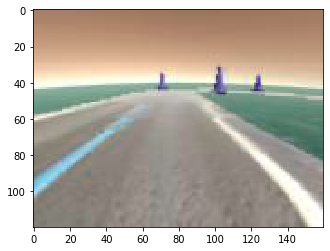

In [19]:
im = cv2.imread(data_path + str(1) + "_cam-image_array_.jpg")
image = plt.imshow(im)
for i in range(2, 1000):
    clear_output(wait=True)
    im = cv2.imread(data_path + str(i) + "_cam-image_array_.jpg")
    plt.imshow(im)
    time.sleep(0.1)
    plt.show()

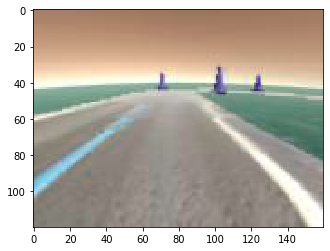

In [7]:
im = cv2.imread(data_path + str(1) + "_cam-image_array_.jpg")
plt.imshow(im)
plt.show()

In [20]:
sorted(numbers)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185